In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm

from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal

In [45]:
# Step 1: Load and Preprocess Data
# Assuming the data is provided as a CSV file with a column 'Value'
data = pd.read_csv('dataset1.csv')
log_prices = data['Value']

def test_stationarity(timeseries):
    """Perform Augmented Dickey-Fuller test to check stationarity."""
    result = adfuller(timeseries)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    return result[1] < 0.05  # Stationary if p-value < 0.05
    
# Check stationarity
if not test_stationarity(log_prices):
    log_prices_diff = log_prices.diff().dropna()  # Differencing to remove non-stationarity
else:
    log_prices_diff = log_prices

ADF Statistic: -1.6013177782252705
p-value: 0.4829314722663666


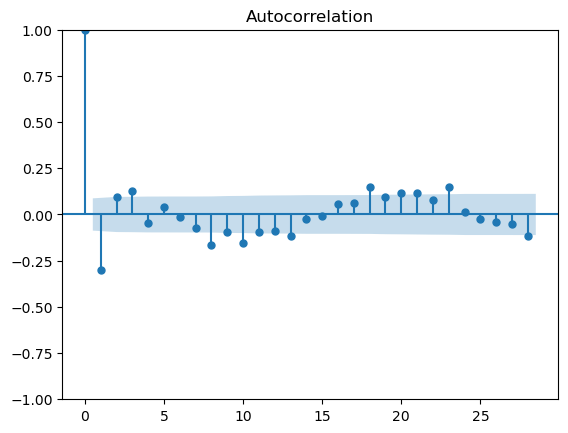

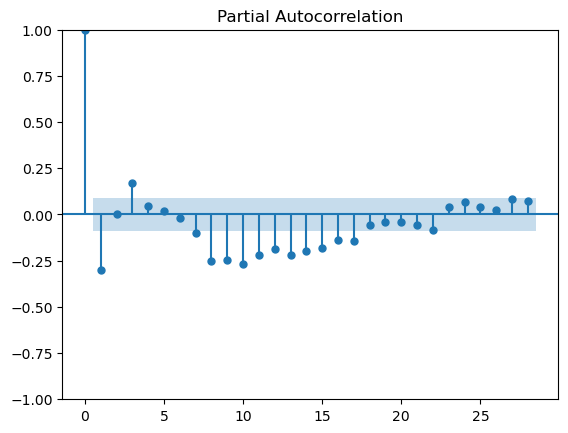

In [47]:
# Step 2: Analyze Seasonality
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(log_prices_diff)
plot_pacf(log_prices_diff)
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  

Best Order (p, q): (3, 2)
                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  503
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -187.482
Date:                Tue, 28 Jan 2025   AIC                            388.964
Time:                        13:30:25   BIC                            418.508
Sample:                             0   HQIC                           400.554
                                - 503                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0013      0.011     -0.118      0.906      -0.022       0.020
ar.L1          1.4153      0.042     33.708      0.000       1.333       1.498
ar.L2         -0.0745     

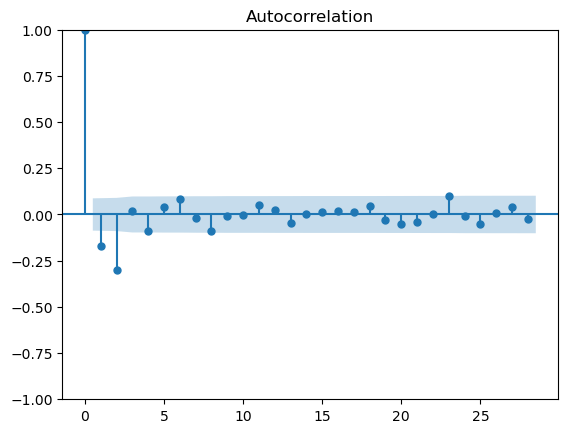

In [57]:
# Step 3: Fit ARMA Model
# Select optimal (p, q) using AIC/BIC criteria
best_aic = np.inf
best_order = None
best_model = None

# Set the AR lag (p) based on PACF
p_max = 3  # Last significant PACF lag

# Set the MA lag (q) based on ACF (if available), or use a reasonable default
q_max = 3  # You may need to adjust this after checking the ACF plot


for p in range(p_max + 1):
    for q in range(q_max + 1):
        try:
            model = ARIMA(log_prices_diff, order=(p, 0, q)).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = (p, q)
                best_model = model
        except:
            continue

print(f"Best Order (p, q): {best_order}")
print(best_model.summary())

# Check if residuals are white noise
plot_acf(residuals)
plt.show()

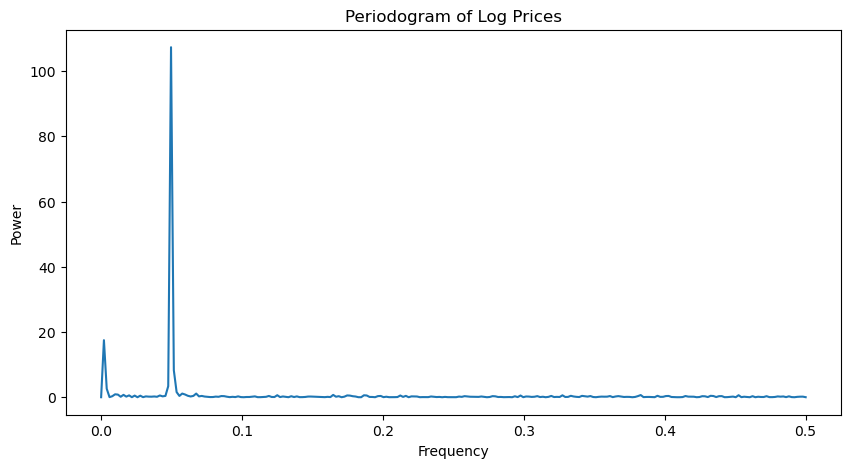

Identified seasonal frequency: 0.0496031746031746
Based on seasonality alone, the log-price is expected to be negative on 23/02/2025.


In [59]:
# Step 3: Forecast Future Values Based on Seasonality Alone
from scipy.signal import periodogram

frequencies, spectrum = periodogram(log_prices)
plt.figure(figsize=(10, 5))
plt.plot(frequencies, spectrum)
plt.title("Periodogram of Log Prices")
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.show()

# Identify the dominant seasonal frequency
seasonal_freq = frequencies[np.argmax(spectrum)]
print(f"Identified seasonal frequency: {seasonal_freq}")

# Compute seasonality-based forecast for 23/02/2025
seasonal_trend = np.sin(2 * np.pi * seasonal_freq * len(log_prices))
pred_seasonality = log_prices.iloc[-1] + seasonal_trend
if pred_seasonality > 0:
    print("Based on seasonality alone, the log-price is expected to be positive on 23/02/2025.")
else:
    print("Based on seasonality alone, the log-price is expected to be negative on 23/02/2025.")

In [61]:
# Step 4: Forecast Future Values
forecast = best_model.get_forecast(steps=1)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Since the forecast_mean might not have a direct index, use `.iloc[0]` to get the value
mu = forecast_mean.iloc[0]  # Predicted mean for the next step
sigma = np.sqrt(forecast.var_pred_mean)

# Last observed log-price
pt = log_prices.iloc[-1]

P_up = 1 - norm.cdf(pt, loc=mu, scale=sigma)
P_down = norm.cdf(pt, loc=mu, scale=sigma)
P_in_range = norm.cdf(-0.29, loc=mu, scale=sigma) - norm.cdf(-0.49, loc=mu, scale=sigma)
P_out_of_range = 1 - P_in_range

print(f"P(Up): {P_up}, P(Down): {P_down}, P(In Range): {P_in_range}, P(Out of Range): {P_out_of_range}")

P(Up): [0.76721962], P(Down): [0.23278038], P(In Range): [0.13716381], P(Out of Range): [0.86283619]


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [63]:
# Step 5: Trading Decision
# Payoff calculation
bet_prices = {"up": 0.16, "down": 0.84, "in_range": 0.77, "out_of_range": 0.23}

expected_payoff = {
    "up": P_up  - bet_prices["up"],
    "down": P_down - bet_prices["down"],
    "in_range": P_in_range - bet_prices["in_range"],
    "out_of_range": P_out_of_range - bet_prices["out_of_range"],
}

# Display only expected payoffs greater than 0
for bet, payoff in expected_payoff.items():
    if payoff > 0:
        print(f"Best Bet: {bet}, Expected Payoff: {payoff}")

Best Bet: up, Expected Payoff: [0.60721962]
Best Bet: out_of_range, Expected Payoff: [0.63283619]
